In [1]:
# # check GPU
!nvidia-smi

Fri Jan 13 11:58:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# # pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
!cd mode_connectivity; git checkout geodesics

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 754, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 754 (delta 188), reused 304 (delta 172), pack-reused 385
Receiving objects: 100% (754/754), 37.45 MiB | 22.27 MiB/s, done.
Resolving deltas: 100% (432/432), done.
Branch 'geodesics' set up to track remote branch 'geodesics' from 'origin'.
Switched to a new branch 'geodesics'


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [5]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Training MLP models

In [23]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 5
training_config.seed = 7

# train model a
# model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_a = train_model(*setup_train(training_config), verbose = 1)
#torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# change seed to get different model
training_config.seed = 42

# train model b
# model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_b = train_model(*setup_train(training_config), verbose = 1)
#torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
12.842488527297974
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0942, Accuracy: (97%)
12.912238597869873


KeyboardInterrupt: ignored

# LMC in param space

In [47]:
n_points = 5
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
)
torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 

{'batch_size': 256, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}
{'batch_size': 256, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}

performing naive interpolation
lerp: 0.005301713943481445
Average loss: 0.0334, Accuracy: (99%)
train: 11.54814887046814
Average loss: 0.0811, Accuracy: (97%)
test: 1.79972505569458
test 2.8371810913085938e-05
lerp: 0.010014533996582031
Average loss: 0.2660, Accuracy: (98%)
train: 10.794021844863892
Average loss: 0.2797, Accuracy: (97%)
test: 1.8401477336883545
test 2.8133392333984375e-05
lerp: 0.00944375991821289
Average loss: 1.3403, Accuracy: (91%)
train: 11.253736972808838
Average loss: 1.3384, Accuracy: (90%)
test: 2.2152140140533447
test 3.0994415283203125e-05
lerp: 0.008374929428100586
Average loss: 0.2538, Accuracy: (98%)
train: 11.665367364883423
Average loss: 0.2732, Accuracy: (97%)
test: 1.783318042755127
test 2.6226043701171875e-05
lerp: 0.008833885192871094
Average loss: 0.0343, Accuracy: (99%)
trai

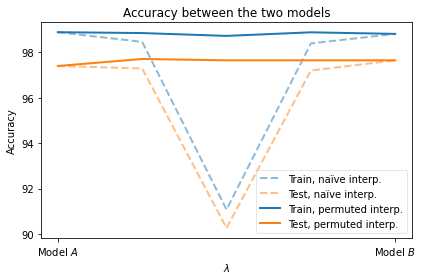

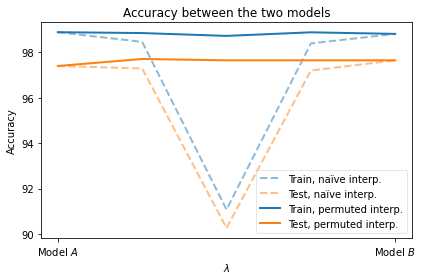

In [48]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [49]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length
from mode_connectivity.utils import metrics
from mode_connectivity.utils import objectives

In [50]:
device, device_kwargs = get_device()

In [51]:
# load in model state_dicts
model_file_path = 'mode_connectivity/model_files/' # use this path in colab
# model_file_path = '../model_files/'

# model_a, model_b, model_pb = (MLP(), MLP(), MLP())
# utils.load_checkpoint(model_a, model_file_path + "mlp_mnist_model_a.pt", device)
# utils.load_checkpoint(model_b, model_file_path + "mlp_mnist_model_b.pt", device)
# utils.load_checkpoint(model_pb, model_file_path + "mlp_mnist_model_pb.pt", device)

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [74]:
train_kwargs = {"batch_size":128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size":512, 'num_workers': 0, 'pin_memory': False}

train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs
)

{'batch_size': 128, 'num_workers': 0, 'pin_memory': False}
{'batch_size': 512, 'num_workers': 0, 'pin_memory': False}


In [101]:
from models.super import SuperModel

N = 10

super_model = SuperModel(MLP, N, weights_a, weights_b).to(device)

losses, euclid_dists = optimise_for_geodesic(
        super_model,
        train_loader,
        device,
        learning_rate = .1,
        return_losses = True,
        return_euclid_dist= True,
    )

Optimising geodesic ...
batch 0 | path loss 0.3162272870540619 | sq euc dist 183.8349151611328
batch 1 | path loss 0.29305699467658997 | sq euc dist 183.83648681640625
batch 2 | path loss 0.28200632333755493 | sq euc dist 183.83963012695312
batch 3 | path loss 0.2818085551261902 | sq euc dist 183.84515380859375
batch 4 | path loss 0.27911895513534546 | sq euc dist 183.8507080078125
batch 5 | path loss 0.2752339839935303 | sq euc dist 183.85580444335938
batch 6 | path loss 0.26831406354904175 | sq euc dist 183.863037109375
batch 7 | path loss 0.26161664724349976 | sq euc dist 183.87149047851562
batch 8 | path loss 0.25857746601104736 | sq euc dist 183.87985229492188
batch 9 | path loss 0.2556990087032318 | sq euc dist 183.8870849609375
batch 10 | path loss 0.25552070140838623 | sq euc dist 183.895263671875
batch 11 | path loss 0.24896346032619476 | sq euc dist 183.90330505371094
batch 12 | path loss 0.23464450240135193 | sq euc dist 183.9143829345703
batch 13 | path loss 0.2335111796855

KeyboardInterrupt: ignored

# I ONLY WORKED UP TO HERE (CHARLIE)

In [ ]:
loss_plots = [loss.detach().cpu() for loss in losses]
sq_euclid_dist_plots = [euclid_dist.detach().cpu() for euclid_dist in euclid_dists]

Text(0, 0.5, 'path action via (squared) euclid dist')

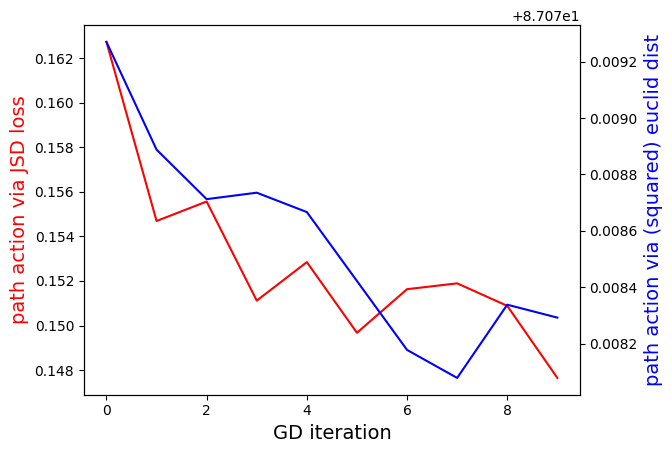

In [ ]:
fig, ax = plt.subplots()

loss_type = 'JSD loss'

ax.plot(loss_plots, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euclid_dist_plots, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

In [104]:
!cd mode_connectivity && git status

On branch geodesics
Your branch is up to date with 'origin/geodesics'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	deleted:    debug_training.py
	modified:   geodesic_opt.py
	modified:   lmc.py
	modified:   training.py
	modified:   utils/data.py
	modified:   utils/metrics.py
	modified:   utils/training_utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	models/debug_training.py
	models/super.py
	super.py

no changes added to commit (use "git add" and/or "git commit -a")
